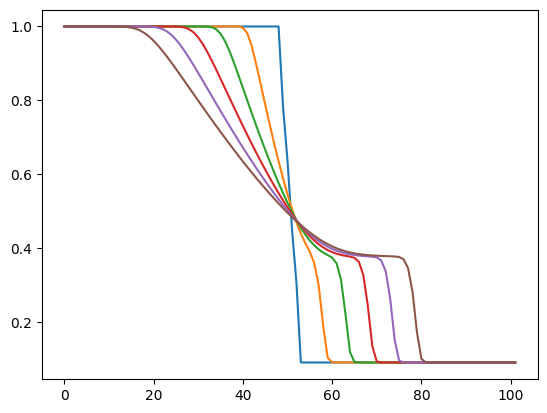

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
dx = 0.1
T_MAX = 50
N = 102

# Initial conditions
h = np.array([1]*51 + [0.09]*51)
u = np.zeros(N)
hu = h * u

initial_height = h.copy()
initial_velocity = u.copy()

def wave_speed(momentum, height):
    velocity = np.where(height != 0, momentum / height, 0)
    speed_plus = velocity + np.sqrt(height)
    speed_minus = velocity - np.sqrt(height)
    return np.round(np.maximum(np.abs(speed_plus), np.abs(speed_minus)), 4)

def shock_speed(A, B):
    return np.where((A != 0) & (B != 0), np.abs(A / B), 0)

def interface_values(Q_1, Q_2, slope_Q_1, dx):
    c = np.where(Q_1 > Q_2, 1, -1)
    return np.round(Q_1 - c * np.abs(slope_Q_1) * dx / 2, 2)

def slope(Q1, Q2, direction, dx):
    c = 1 if direction == "right" else -1
    return (Q2 - Q1) / (c * dx)

def time_CFL_consistency(CFL, dt, dx, max_speed):
    if CFL >= 1:
        print("Warning: CFL value crossed 1")
        while CFL >= 1:
            dt -= 0.05
            CFL = dt / dx * max_speed
        print(f"New time step: {dt}, new CFL: {CFL}")
    return dt


def upwind_flux(h_L, h_R, hu_L, hu_R):
    # Compute velocities
    u_L = np.where(h_L > 0, hu_L / h_L, 0)
    u_R = np.where(h_R > 0, hu_R / h_R, 0)

    # Compute wave speeds
    c_L = np.abs(u_L) + np.sqrt(h_L)
    c_R = np.abs(u_R) + np.sqrt(h_R)
    c_max = np.maximum(c_L, c_R)

    # Compute fluxes
    F_L = np.vstack([hu_L, hu_L**2/np.where(h_L > 0, h_L, 1) + 0.5*h_L**2])
    F_R = np.vstack([hu_R, hu_R**2/np.where(h_R > 0, h_R, 1) + 0.5*h_R**2])

    # Compute upwind flux
    Q_L = np.vstack([h_L, hu_L])
    Q_R = np.vstack([h_R, hu_R])
    F_upwind = 0.5 * (F_L + F_R - c_max[np.newaxis, :] * (Q_R - Q_L))

    return F_upwind[0], F_upwind[1]


T = 0
solution = []
while T < T_MAX:
    # Calculate fluxes for all interfaces
    Fl_con, Fl_mom = upwind_flux(h[:-1], h[1:], hu[:-1], hu[1:])

    # Calculate maximum wave speed
    max_speed = np.max(wave_speed(hu, h))

    # Calculate time step
    dt = 0.8 * dx / max_speed  # Using CFL number of 0.8 for stability

    # Update interior points
    h[1:-1] -= dt / dx * (Fl_con[1:] - Fl_con[:-1])
    hu[1:-1] -= dt / dx * (Fl_mom[1:] - Fl_mom[:-1])

    # Apply boundary conditions (e.g., reflective)
    h[0], h[-1] = h[1], h[-2]
    hu[0], hu[-1] = -hu[1], -hu[-2]

    # Update velocity
    u = np.where(h > 1e-6, hu / h, 0)
    solution.append(np.copy(h))
    # Plot
    # plt.clf()
    # plt.plot(u)
    # plt.title(f"Time step: {T}")
    # plt.xlabel("Position")
    # plt.ylabel("Height")
    # plt.ylim(0, 1.2)
    # plt.pause(0.01)

    T += 1

for i in np.arange(1,T,9):
    plt.plot(solution[i])

In [8]:
godunov = solution

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81  # gravitational acceleration (m/s^2)

# Initial conditions for dam-break problem
def initial_conditions(x, x_dam, h_left, h_right):
    """Set initial conditions for water height and velocity."""
    h = np.where(x < x_dam, h_left, h_right)
    u = np.zeros_like(x)
    return h, u

# Compute fluxes
def compute_flux(h, u):
    """Compute flux vector for shallow water equations."""
    flux_h = h * u
    flux_momentum = h * u**2 + 0.5 * g * h**2
    return np.array([flux_h, flux_momentum])

# Godunov's method: solving Riemann problem at each interface
def godunov_flux(h_L, u_L, h_R, u_R):
    """Compute numerical flux using Godunov's method."""
    c_L = np.sqrt(g * h_L)
    c_R = np.sqrt(g * h_R)

    s_L = min(u_L - c_L, u_R - c_R)
    s_R = max(u_L + c_L, u_R + c_R)

    flux_L = compute_flux(h_L, u_L)
    flux_R = compute_flux(h_R, u_R)

    if s_L > 0:
        return flux_L
    elif s_R < 0:
        return flux_R
    else:
        return (s_R * flux_L - s_L * flux_R + s_L * s_R * (np.array([h_R, h_R*u_R]) - np.array([h_L, h_L*u_L]))) / (s_R - s_L)

# Update solution using finite volume method
def update_solution(h, u, dx, dt, epsilon):
    """Update solution using Godunov's method."""
    N = len(h)
    new_h = np.copy(h)
    new_u = np.copy(u)

    fluxes_h = np.zeros(N+1)
    fluxes_momentum = np.zeros(N+1)

    # Compute fluxes at cell interfaces
    for i in range(N - 1):
        h_L, u_L = h[i], u[i]
        h_R, u_R = h[i + 1], u[i + 1]

        F = godunov_flux(h_L, u_L, h_R, u_R)
        fluxes_h[i + 1] = F[0]
        fluxes_momentum[i + 1] = F[1]

    # Update cell values
    for i in range(1, N - 1):  # Avoid boundary cells
        new_h[i] -= dt / dx * (fluxes_h[i + 1] - fluxes_h[i])
        new_u[i] = (new_u[i] * h[i] - dt / dx * (fluxes_momentum[i + 1] - fluxes_momentum[i])) / max(new_h[i], epsilon)

    # Reflective boundary conditions
    new_h[0] = new_h[1]
    new_u[0] = -new_u[1]
    new_h[-1] = new_h[-2]
    new_u[-1] = -new_u[-2]

    return new_h, new_u

# CFL condition to calculate time step size
def compute_time_step(h, u, dx, CFL):
    """Compute time step size based on CFL condition."""
    c = np.sqrt(g * h)  # wave speed
    max_speed = np.max(np.abs(u) + c)  # max characteristic speed
    return CFL * dx /( 2*max_speed)

# Main simulation loop returning solution array
def simulate_dam_break(x_min, x_max, nx, x_dam, h_left, h_right, t_max, CFL, epsilon):
    """Simulate dam-break problem using shallow water equations."""
    x = np.linspace(x_min, x_max, nx)
    dx = x[1] - x[0]

    h, u = initial_conditions(x, x_dam, h_left, h_right)

    t = 0.0
    sol_h = []  # Store water height at each time step
    sol_u = []  # Store velocity at each time step

    while t < t_max:
        dt = compute_time_step(h, u, dx, CFL)
        if t + dt > t_max:
            dt = t_max - t

        # Update solution
        h_new, u_new = update_solution(h, u, dx, dt, epsilon)

        t += dt
        h[:] = h_new[:]
        u[:] = u_new[:]

        sol_h.append(np.copy(h))  # Store water height for the current time step
        sol_u.append(np.copy(u))  # Store velocity for the current time step

    return np.array(sol_h), np.array(sol_u)

# Parameters for simulation
x_min = 0.0      # start of domain (m)
x_max = 10.0     # end of domain (m)
nx = 400         # number of grid points
x_dam = 5.0      # location of dam (m)
h_left = 1.0     # water height on left side of dam (m)
h_right = 0.009    # water height on right side of dam (m)
t_max = 50      # simulation time (s)
CFL_number = 0.9 # Courant number
epsilon = 0   # Small threshold to prevent division by zero

# Run simulation
solution_h, solution_u = simulate_dam_break(
    x_min=x_min,
    x_max=x_max,
    nx=nx,
    x_dam=x_dam,
    h_left=h_left,
    h_right=h_right,
    t_max=t_max,
    CFL=CFL_number,
    epsilon=epsilon
)


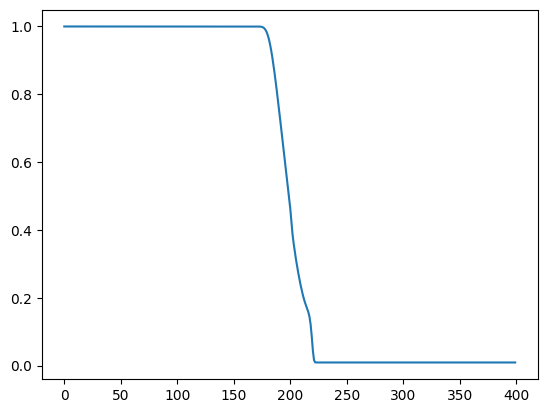

In [10]:
plt.plot(solution_h[50,:])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 1  # Gravitational acceleration (m/s^2)

# Compute fluxes for shallow water equations
def compute_flux(h, u):
    """
    Compute flux for shallow water equations.

    Parameters:
    - h: Water height
    - u: Velocity

    Returns:
    - Flux array [flux_h, flux_momentum]
    """
    momentum = h * u  # Momentum (hu)
    flux_h = momentum  # Flux of height
    flux_momentum = momentum * u + 0.5 * g * h**2  # Flux of momentum
    return np.array([flux_h, flux_momentum])

# Update solution using Rusanov method
def update_solution_rusanov(h, u, dx, dt):
    """
    Update solution using Rusanov method.

    Parameters:
    - h: Water height array.
    - u: Velocity array.
    - dx: Spatial grid size.
    - dt: Time step size.

    Returns:
    - Updated water height and velocity arrays.
    """
    N = len(h)

    # Initialize new arrays for height and velocity
    new_h = np.zeros_like(h)
    new_u = np.zeros_like(u)

    # Compute the wave speed (lambda) for the Rusanov method
    lambda_ = np.maximum(np.sqrt(g * h) + np.abs(u), np.sqrt(g * h) - np.abs(u))

    for i in range(1, N - 1):
        # Compute fluxes for current and neighboring cells
        F_i_minus_1 = compute_flux(h[i - 1], u[i - 1])
        F_i = compute_flux(h[i], u[i])
        F_i_plus_1 = compute_flux(h[i + 1], u[i + 1])

        # Rusanov update for height
        new_h[i] = 0.5 * (h[i - 1] + h[i + 1]) - 0.5 * lambda_[i] * (F_i_plus_1[0] - F_i_minus_1[0])

        # Rusanov update for velocity
        new_u[i] = 0.5 * (u[i - 1] + u[i + 1]) - 0.5 * lambda_[i] * (F_i_plus_1[1] / h[i + 1] - F_i_minus_1[1] / h[i - 1])

    # Apply boundary conditions (constant extrapolation)
    new_h[0], new_h[-1] = h[0], h[-1]
    new_u[0], new_u[-1] = u[0], u[-1]

    return new_h, new_u

# CFL condition to compute time step size
def compute_time_step(h, u, dx, CFL):
    """
    Compute time step size based on CFL condition.

    Parameters:
    - h: Water height array.
    - u: Velocity array.
    - dx: Spatial grid size.
    - CFL: Courant number.

    Returns:
    - Time step size (dt).
    """
    # Compute the maximum eigen velocity at each time step
    lplus = max(np.sqrt(g * h) + np.abs(u))
    lminus = max(np.sqrt(g * h) - np.abs(u))
    lambda_ = np.maximum(lplus, lminus)
    max_wave_speed = 2*lambda_
    dt = CFL * dx / max_wave_speed
    return dt
# Constants for the simulation
x_min = -40.0
x_max = 40.0
nx = 400
dx = (x_max - x_min) / nx
CFL = 0.5  # Courant number
t_max = 10

# Initial conditions
x = np.linspace(x_min, x_max, nx)
h = np.where(x < 0, 1.0, 0.1)  # Initial water height (dam break)
u = np.zeros(nx)  # Initial velocity
lplus = max(np.sqrt(g * h) + (u))
lminus =max(np.sqrt(g * h) - (u))
l = np.maximum(lplus,lminus )
CFL = 0.01*l/dx
# Simulation loop
t = 0.0
time_series_h = [h.copy()]  # To store height solutions over time
time_series_u = [u.copy()]  # To store velocity solutions over time

while t < t_max:
    # Compute time step using CFL condition
    dt = compute_time_step(h, u, dx, CFL)

    if t + dt > t_max:
        dt = t_max - t  # Adjust last time step to reach t_max

    # Update solution
    h, u = update_solution_rusanov(h, u, dx, dt)

    # Store the updated solution
    time_series_h.append(h.copy())
    time_series_u.append(u.copy())

    # Increment time
    t += dt
    plt.plot(x, h, label="Height (h)")
    plt.plot(x, u, label="Velocity (u)")
    plt.show()
# # Plot the results (final time step)
# plt.figure(figsize=(10, 6))
# plt.plot(x, time_series_h[-1], label="Water Height (h)")
# plt.plot(x, time_series_u[-1], label="Velocity (u)")
# plt.xlabel("x")
# plt.ylabel("Height / Velocity")
# plt.title("Dam-Break Simulation (Final State)")
# plt.legend()
# plt.grid()
# plt.show()


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99569236, 0.99769063,
       1.00259606, 0.90402095, 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       ])